In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *

from pyspark.ml  import Pipeline     
from pyspark.sql.functions import mean,col,split, col, regexp_extract, when, lit
import pyspark.sql.functions as f

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *

#create session in order to be capable of accessing all Spark API
spark = SparkSession \
    .builder \
    .appName("Purchase") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

22/08/09 02:59:39 WARN Utils: Your hostname, Rambhupals-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.0.0.76 instead (on interface en0)
22/08/09 02:59:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/09 02:59:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/08/09 02:59:40 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/08/09 02:59:40 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/08/09 02:59:40 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


In [4]:
csv_files = glob("./*.csv")
csv_files

[]

22/08/09 04:30:59 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1067167 ms exceeds timeout 120000 ms
22/08/09 04:31:00 WARN SparkContext: Killing executors is not supported by current scheduler.


In [5]:
flight_csv = sorted([i for i in csv_files if len(i.split("/")[1].rsplit(".",1)[0])==4])
flight_csv

['./1987.csv',
 './1988.csv',
 './1989.csv',
 './1990.csv',
 './1991.csv',
 './1992.csv',
 './1993.csv',
 './1994.csv',
 './1995.csv',
 './1996.csv',
 './1997.csv',
 './1998.csv',
 './1999.csv',
 './2000.csv',
 './2001.csv',
 './2002.csv',
 './2003.csv',
 './2004.csv',
 './2005.csv',
 './2006.csv',
 './2007.csv',
 './2008.csv']

In [97]:
c=0
for file in flight_csv:
    if c==0:
        df = spark.read.csv(file, header = "true")
    else:
        df_temp = spark.read.csv(file, header = "true")
        df = df.unionByName(df_temp)
        print((file, df.count(), len(df.columns)))
    c+=1

('./1988.csv', 6513922, 29)


('./1989.csv', 11555122, 29)


('./1990.csv', 16826015, 29)


('./1991.csv', 21902940, 29)


('./1992.csv', 26995097, 29)


('./1993.csv', 32065598, 29)


('./1994.csv', 37245646, 29)


('./1995.csv', 42573081, 29)


('./1996.csv', 47925064, 29)


('./1997.csv', 53336907, 29)


('./1998.csv', 58721628, 29)


('./1999.csv', 64249512, 29)


('./2000.csv', 69932559, 29)


('./2001.csv', 75900339, 29)


('./2002.csv', 81171698, 29)


('./2003.csv', 87660238, 29)


('./2004.csv', 94789508, 29)


('./2005.csv', 101930104, 29)


('./2006.csv', 109072026, 29)


('./2007.csv', 116525241, 29)


('./2008.csv', 118914458, 29)


In [137]:
print((df.count(), len(df.columns)))

(118914458, 29)


In [116]:
df_journies = df.groupBy('Origin', 'Dest').count().toPandas()

In [183]:
df_journies_sorted = df_journies.sort_values(by=['count'], ascending=False)[:12]
df_journies_sorted.head(10)

,Origin,Dest,count
6310,SFO,LAX,329370
4235,LAX,SFO,328105
7017,LAX,LAS,284494
5594,LAS,LAX,278653
5633,PHX,LAX,273286
2847,LAX,PHX,272681
2090,ORD,MSP,243470
7683,MSP,ORD,242933
2150,PHX,LAS,233977
2081,LAS,PHX,232467


In [184]:
airport_names=[]
for i in range(len(df_journies_sorted)):
    origin = df_journies_sorted.iloc[i]['Origin']
    destination = df_journies_sorted.iloc[i]['Dest']
    journey = origin + '-' + destination
    airport_names.append(journey)
df_journies_sorted['trips'] = airport_names

Text(0.5, 1.0, 'Total number of Trips between high traffic Airports')

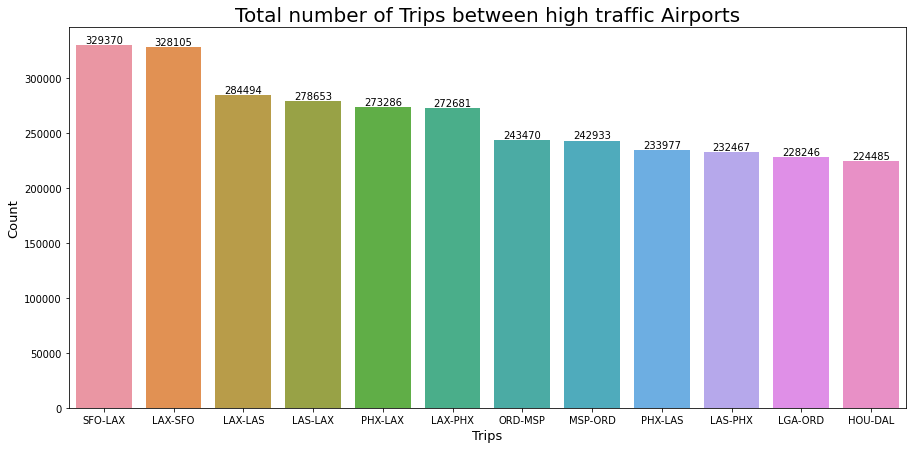

In [206]:
plt.figure(figsize=(15,7))
ax = sns.barplot(x='trips', y='count', data=df_journies_sorted)
ax.bar_label(ax.containers[0])
plt.xlabel('Trips',size=13)
plt.ylabel('Count',size=13)
plt.title('Total number of Trips between high traffic Airports',size=20)

In [8]:
drop_columns=['Unnamed: 0','CRSDepTime','CRSArrTime','ActualElapsedTime','CRSElapsedTime',
                'AirTime','Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut','CancellationCode','Diverted',
                'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
df = df.drop(*drop_columns)
len(df.columns)

12

In [63]:
df_flight = df.groupBy('UniqueCarrier', 'Cancelled').count().toPandas()

Text(0.5, 1.0, 'Airlines-Flight Cancellation Proportions')

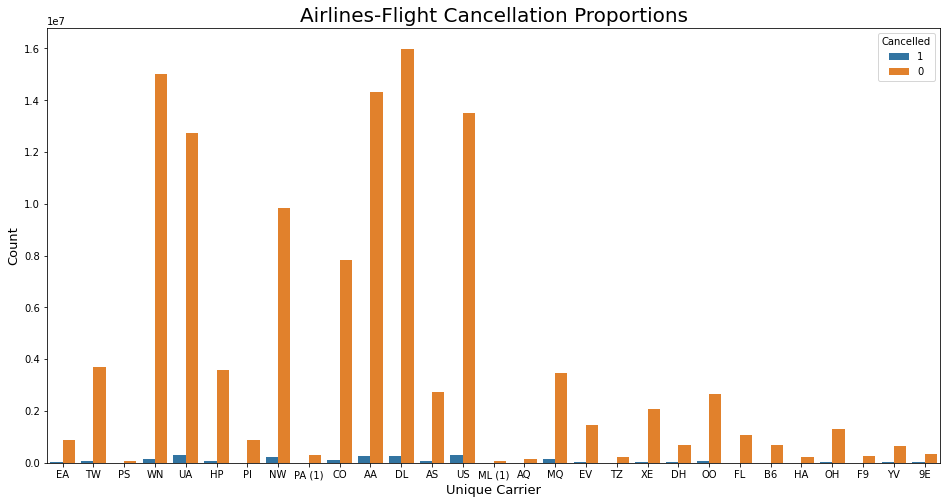

In [204]:
plt.figure(figsize=(16,8))
ax = sns.barplot(x='UniqueCarrier', y='count', hue='Cancelled', data=df_flight)
plt.xlabel('Unique Carrier',size=13) 
plt.ylabel('Count',size=13)   
plt.title('Airlines-Flight Cancellation Proportions',size=20)

In [87]:
df_year = df.groupBy('Year', 'Cancelled').count().toPandas()

Text(0.5, 1.0, 'Yearly-Flight Cancellation Proportions')

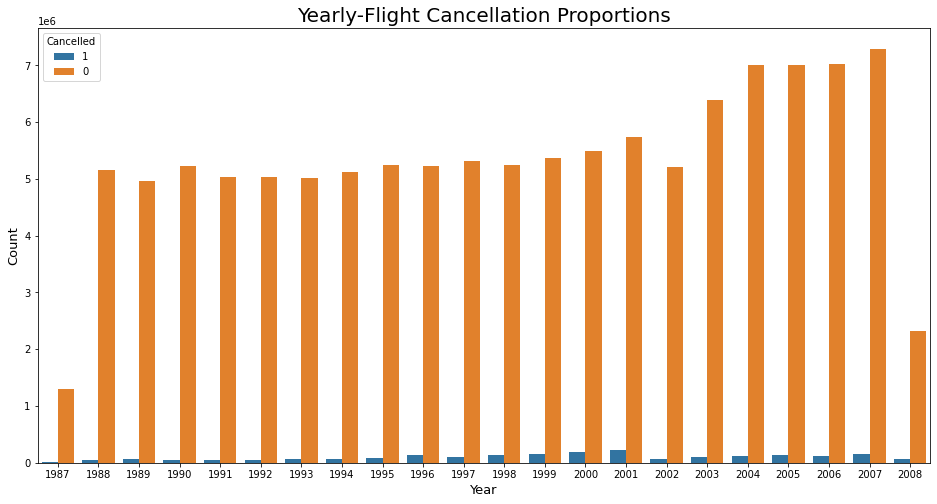

In [208]:
plt.figure(figsize=(16,8))
ax = sns.barplot(x='Year', y='count', hue='Cancelled', data=df_year)
plt.xlabel('Year',size=13) 
plt.ylabel('Count',size=13)   
plt.title('Yearly-Flight Cancellation Proportions',size=20)

In [9]:
# Cancelled flights percentage in data
cancelled = df.filter(df.Cancelled==1)
cancelled = cancelled.drop('Cancelled')
cancelled.show()

+----+-----+----------+---------+-------+-------+-------------+---------+-------+--------+--------+
|Year|Month|DayofMonth|DayOfWeek|DepTime|ArrTime|UniqueCarrier|FlightNum|TailNum|ArrDelay|DepDelay|
+----+-----+----------+---------+-------+-------+-------------+---------+-------+--------+--------+
|1987|   10|        12|        1|     NA|     NA|           PS|     1453|     NA|      NA|      NA|
|1987|   10|        12|        1|     NA|     NA|           PS|     1454|     NA|      NA|      NA|
|1987|   10|         6|        2|     NA|     NA|           PS|     1457|     NA|      NA|      NA|
|1987|   10|        29|        4|     NA|     NA|           PS|     1459|     NA|      NA|      NA|
|1987|   10|        22|        4|     NA|     NA|           PS|     1465|     NA|      NA|      NA|
|1987|   10|         5|        1|     NA|     NA|           PS|     1480|     NA|      NA|      NA|
|1987|   10|        28|        3|     NA|     NA|           PS|     1502|     NA|      NA|      NA|


In [11]:
cancelled_UniqueCarrier = cancelled.groupBy('UniqueCarrier').count().select('UniqueCarrier', f.col('Count')).toPandas()
cancelled_UniqueCarrier.set_index('UniqueCarrier', inplace=True)

<AxesSubplot:title={'center':'Which airline cancelled flights highest number of times?'}, ylabel='Count'>

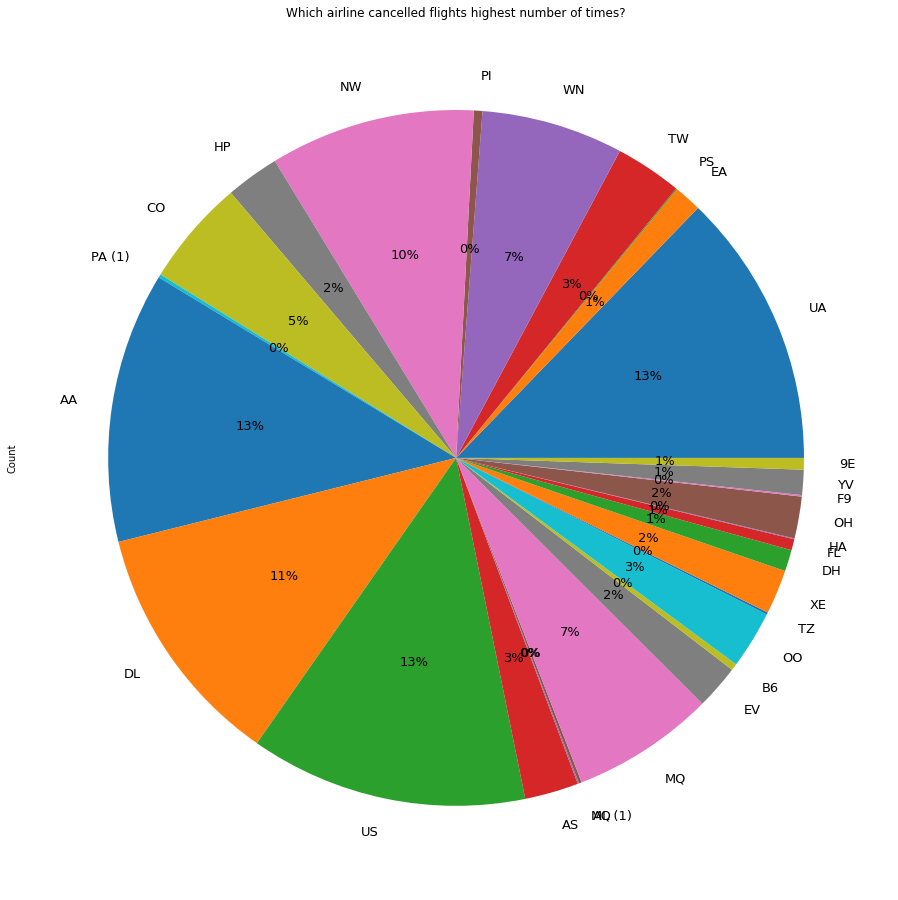

In [209]:
cancelled_UniqueCarrier.plot(kind='pie', y='Count', autopct='%1.0f%%', fontsize=13, legend=False,
                            title='Which airline cancelled flights highest number of times?',
                            figsize=(16,16))

In [211]:
cancelled_year = cancelled.groupBy('Year').count().select('Year', f.col('Count')).toPandas()
cancelled_year.set_index('Year', inplace=True)

In [212]:
cancelled_year_counts = cancelled_year['Count']
year_text = ['{:0.1f}%'.format(v) for v in (cancelled_year_counts/cancelled.count()*100)]

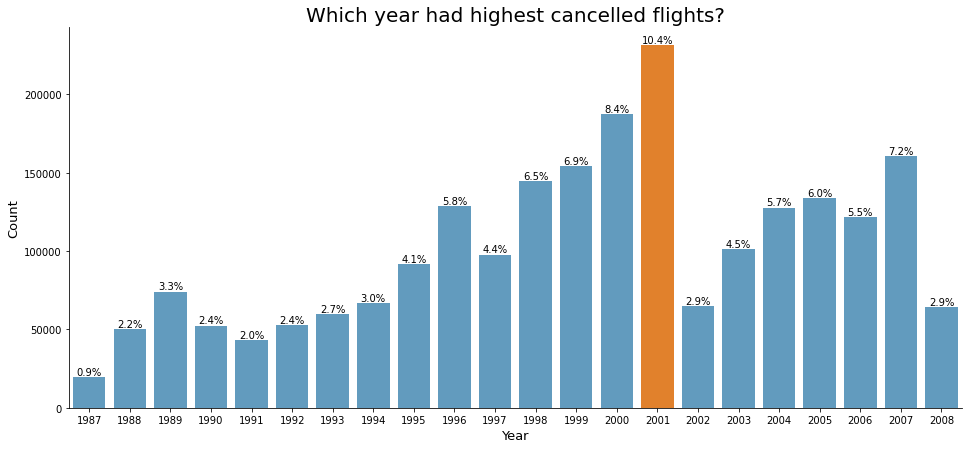

In [217]:
base_color = '#539ecd'
alt=sns.color_palette()[1]
plt.figure(figsize=(16,7))
colors = [base_color if (x < cancelled_year_counts.max()) else alt for x in cancelled_year_counts]
sns.barplot(x=cancelled_year.index,y=cancelled_year_counts, palette=colors);     
plt.xlabel('Year',size=13) 
plt.ylabel('Count',size=13)   
plt.title('Which year had highest cancelled flights?',size=20) 

for i in range (cancelled_year_counts.shape[0]):
    plt.text(i,                           
             cancelled_year_counts.values[i],       
             year_text[i],                 
             ha='center',                  
             va='bottom')
sns.despine()

In [214]:
df = df.filter(df.Cancelled==0)
flight = df.drop('Cancelled')

+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+----------------+--------+------------+------------+--------+-------------+-----------------+
|Year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|ArrTime|CRSArrTime|UniqueCarrier|FlightNum|TailNum|ActualElapsedTime|CRSElapsedTime|AirTime|ArrDelay|DepDelay|Origin|Dest|Distance|TaxiIn|TaxiOut|CancellationCode|Diverted|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|
+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+----------------+--------+------------+------------+--------+-------------+-----------------+
|1987|   10|        14|        3|    741|       730|    912|       849|           PS|     1451|     NA|               91|   

In [218]:
flight.na.drop()

DataFrame[Year: string, Month: string, DayofMonth: string, DayOfWeek: string, DepTime: string, CRSDepTime: string, ArrTime: string, CRSArrTime: string, UniqueCarrier: string, FlightNum: string, TailNum: string, ActualElapsedTime: string, CRSElapsedTime: string, AirTime: string, ArrDelay: string, DepDelay: string, Origin: string, Dest: string, Distance: string, TaxiIn: string, TaxiOut: string, CancellationCode: string, Diverted: string, CarrierDelay: string, WeatherDelay: string, NASDelay: string, SecurityDelay: string, LateAircraftDelay: string]

In [219]:
flight.count()

116684126

In [220]:
year = flight.groupBy('Year').count().select('Year', f.col('Count')).toPandas()
year.set_index('Year', inplace=True)

In [221]:
Year_counts = year['Count']
year_text = ['{:0.1f}%'.format(v) for v in (Year_counts/flight.count()*100)]

In [222]:
Year_counts

Year
1987    1292141
1988    5151933
1989    4967035
1990    5218435
1991    5033420
1992    5039321
1993    5010656
1994    5113308
1995    5235530
1996    5223447
1997    5314080
1998    5240212
1999    5373573
2000    5495557
2001    5736582
2002    5206216
2003    6387071
2004    7001513
2005    7006866
2006    7019988
2007    7292467
2008    2324775
Name: Count, dtype: int64

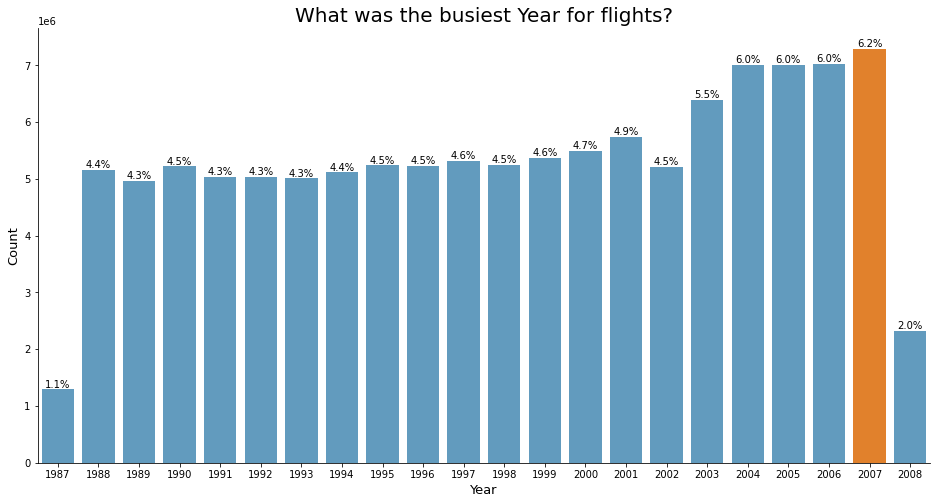

In [223]:
base_color = '#539ecd'
alt=sns.color_palette()[1]
plt.figure(figsize=(16,8))
colors = [base_color if (x < Year_counts.max()) else alt for x in Year_counts]
sns.barplot(x=year.index,y=Year_counts, palette=colors);     
plt.xlabel('Year',size=13) 
plt.ylabel('Count',size=13)   
plt.title('What was the busiest Year for flights?',size=20) 

for i in range (Year_counts.shape[0]):
    plt.text(i,                           
             Year_counts.values[i],       
             year_text[i],                 
             ha='center',                  
             va='bottom')
sns.despine()     

In [224]:
month = flight.groupBy('Month').count().select('Month', f.col('Count')).toPandas()
month.set_index('Month', inplace=True)

In [225]:
Month_counts = month['Count']
Month_text = ['{:0.1f}%'.format(v) for v in (Month_counts/flight.count()*100)]

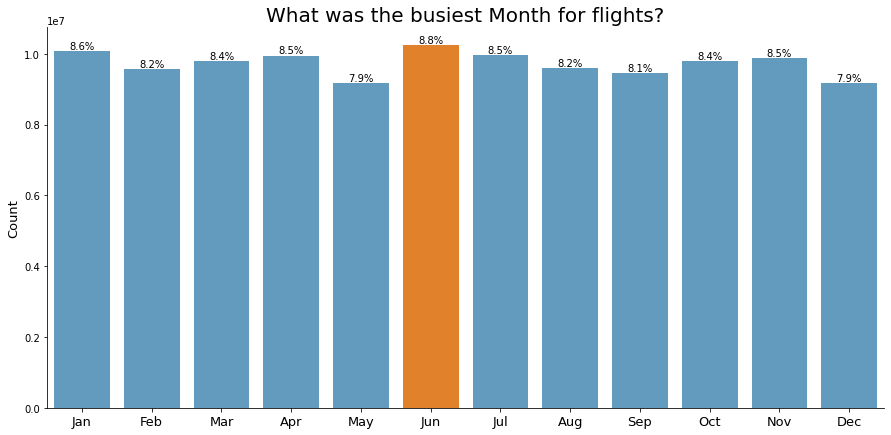

In [226]:
plt.figure(figsize=(15,7))
colors = [base_color if (x < Month_counts.max()) else alt for x in Month_counts ]
sns.barplot(x=month.index,y=Month_counts, palette=colors);     
plt.xlabel('',size=13)
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9,10,11],
           labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],size=13) 
plt.ylabel('Count',size=13)   
plt.title('What was the busiest Month for flights?',size=20) 
sns.despine()
for i in range (Month_counts.shape[0]):
    plt.text(i,                           
             Month_counts.values[i],       
             Month_text[i],                 
             ha='center',                  
             va='bottom')

In [227]:
day = flight.groupBy('DayofMonth').count().select('DayofMonth', f.col('Count')).toPandas()

In [228]:
day['DayofMonth'] = [ int(i) for i in day['DayofMonth']]
day_sorted = day.sort_values(by=['DayofMonth'], ascending=True)
day_sorted.head()

,DayofMonth,Count
22,1,3813790
30,2,3833628
4,3,3822338
25,4,3800314
10,5,3826832


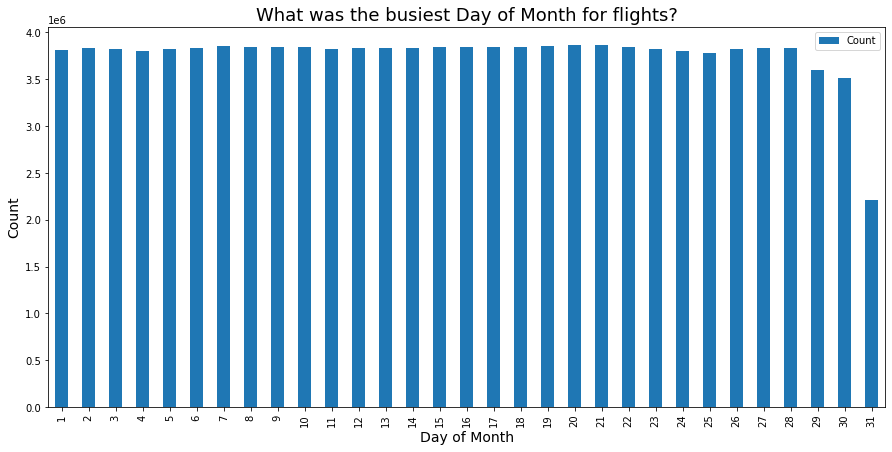

In [229]:
day_sorted.plot.bar(x='DayofMonth', y=['Count'], figsize=(15,7))
plt.xlabel("Day of Month", size=14)
plt.ylabel("Count", size=14)
plt.title("What was the busiest Day of Month for flights?", size=18)
plt.show()

In [230]:
week_days = flight.groupBy('DayOfWeek').count().select('DayOfWeek', f.col('Count')).toPandas()
week_days.set_index('DayOfWeek', inplace=True)

In [231]:
DayOfWeek_counts = week_days['Count']
DayOfWeek_text = ['{:0.1f}%'.format(v) for v in (DayOfWeek_counts/flight.count()*100)]

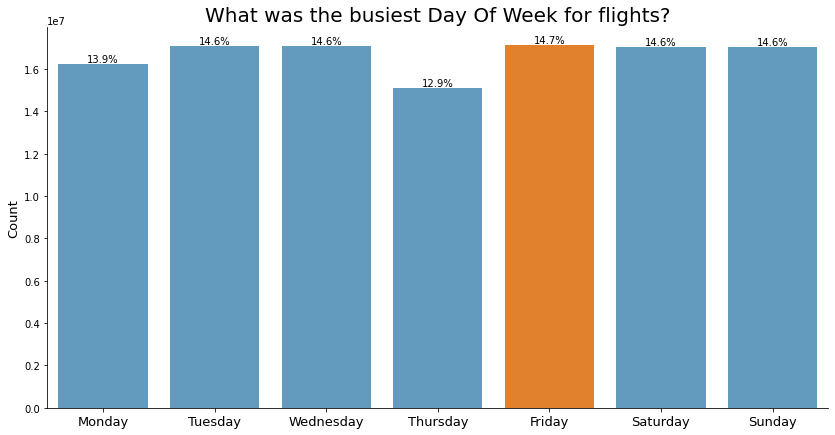

In [232]:
plt.figure(figsize=(14,7))
colors = [base_color if (x < DayOfWeek_counts.max()) else alt for x in DayOfWeek_counts ]
sns.barplot(x=week_days.index,y=DayOfWeek_counts, palette=colors);     
plt.xlabel('',size=20)
plt.xticks(ticks=[0,1,2,3,4,5,6],
           labels=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],size=13) 
plt.ylabel('Count',size=13)   
plt.title('What was the busiest Day Of Week for flights?',size=20) 
sns.despine()
for i in range (DayOfWeek_counts.shape[0]):
    plt.text(i,                           
             DayOfWeek_counts.values[i],       
             DayOfWeek_text[i],                 
             ha='center',                  
             va='bottom')

In [233]:
unique_carrier = flight.groupBy('UniqueCarrier').count().select('UniqueCarrier', f.col('Count')).toPandas()
unique_carrier.set_index('UniqueCarrier', inplace=True)

In [234]:
carrier_counts = unique_carrier['Count']
carrier_text = ['{:0.1f}%'.format(v) for v in (carrier_counts/flight.count()*100)]

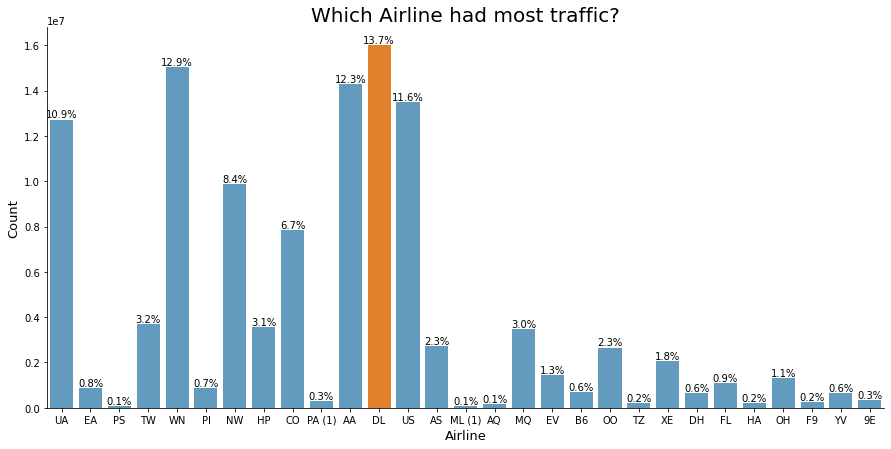

In [235]:
plt.figure(figsize=(15,7))
colors = [base_color if (x < carrier_counts.max()) else alt for x in carrier_counts ]
sns.barplot(x=unique_carrier.index,y=carrier_counts,order=carrier_counts.index, palette=colors);     
plt.xlabel('Airline',size=13) 
plt.ylabel('Count',size=13)   
plt.title('Which Airline had most traffic?',size=20) 
sns.despine()
for i in range (carrier_counts.shape[0]):
    plt.text(i,                           
             carrier_counts.values[i],       
            carrier_text[i],                 
             ha='center',                  
             va='bottom')